# Training a model on Iris dataset and deploying it with Azure ML

Companion code to the blog post at: ...

## Model Training

### Load the Iris dataset

In [ ]:
import pandas as pd
from sklearn.datasets import load_iris

# get the dataset
iris = load_iris()

# Features
X = iris.data

# Labels
y = iris.target

# Combine features and labels into a DataFrame for easy viewing
iris_df = pd.DataFrame(X, columns=iris.feature_names)
iris_df['species'] = pd.Categorical.from_codes(y, iris.target_names)

print(iris_df.head())

### Train the model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

### Run a prediction and print classification report

In [ ]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))


### Export to ONNX format

In [ ]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Define the initial type based on the shape of training data
initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]

# Convert the scikit-learn model to ONNX
onnx_model = convert_sklearn(model, initial_types=initial_type)

# Save the ONNX model to a file
with open("iris_rf_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print("Model exported to iris_rf_model.onnx")

At this point, you should have the model exported. You can use [Netron](https://netron.app/) to view the model, which should look like this:

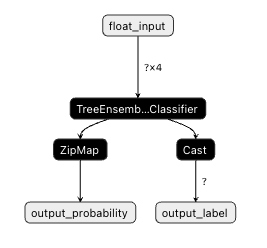

### Test predictions using ONNX runtime

In [ ]:
import numpy as np
import onnxruntime as rt

# Create ONNX Runtime session
session = rt.InferenceSession("iris_rf_model.onnx")

# Prepare sample input data (must be float32)
sample = np.array([[5.1, 3.5, 1.4, 0.2]], dtype=np.float32)

# Get input and output names
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Run inference
pred_onx = session.run([output_name], {input_name: sample})[0]

print("ONNX model prediction:", iris.target_names[pred_onx][0])

## Deployment

There are mutliple ways to deploy a model to Azure ML for inference - serverless and online endpoints for real-time inference, and batch endpoints for long-running batch inference. We're going to deploy an online endpoint for real-time inference.

### Create an Azure ML workspace

Azure ML Workspace is the top-level container for your ML project which will house the models and their versions, the training and inference environments, etc. See: https://learn.microsoft.com/en-us/azure/machine-learning/concept-endpoints?view=azureml-api-2#intuition for container level view of how endpoints, deployments, environments and models are packaged together. 

I'd recommend using either azure-cli or the online portal (https://ml.azure.com/) to create the workspace. Once created, get the subscription id, and resource group by clicking on the workspace at the top-right in the portal.


### Connect to your Azure ML Workspace

In [ ]:
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient

# subscription_id = '<SUBSCRIPTION_ID>'
# resource_group = '<RESOURCE_GROUP>'
# workspace = '<AZUREML_WORKSPACE_NAME>'
subscription_id = "30f15185-d6df-4a7e-9ed2-fb56484c0512"
resource_group = "health-analyzer"
workspace_name = "health-analyzer"

credential = DefaultAzureCredential()
ml_client = MLClient(credential, subscription_id, resource_group, workspace_name)

print("Connected to Azure ML workspace:", ml_client.workspace_name)

### Register the ONNX model

This registers the version of the model, which can then be used to create online endpoints.

In [ ]:
from azure.ai.ml.entities import Model

model = Model(
    path="iris_rf_model.onnx",
    name="iris-rf-onnx",
    description="Random Forest model trained on Iris dataset (ONNX format)",
    type="custom_model",
)

registered_model = ml_client.models.create_or_update(model)

print(f"Registered model: {registered_model.name}, version: {registered_model.version}")

### Test locally with inference HTTP server

It is highly recommended to test your scoring script and the model prediction locally before pushing it to Azure ML. If you're following along with the blog post, here are the steps to do that: 

### Define the endpoint

Now we're ready to define the endpoint, environment, and the deployment.

In [ ]:
from azure.ai.ml.entities import ManagedOnlineEndpoint

endpoint = ManagedOnlineEndpoint(
    name="iris-rf-endpoint",
    description="Online endpoint for Iris RF ONNX model",
    auth_mode="key"
)

ml_client.online_endpoints.begin_create_or_update(endpoint).wait()

print(f"Endpoint '{endpoint.name}' created.")

### Define the environment

The environment defines the runtime and dependencies for your model inference.

In [ ]:
from azure.ai.ml.entities import Environment, ManagedOnlineDeployment, CodeConfiguration

# Register the environment
env = Environment(
    name="iris-rf-onnx-env",
    image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04",
    conda_file="./conda.yml",
    description="Environment for ONNX model inference",
)

ml_client.environments.create_or_update(env)

### Create the deployment

Finally, create the deployment. We're creating one deployment (blue) that will handle 100% of traffic.

In [ ]:

deployment = ManagedOnlineDeployment(
    name="iris-rf-deployment-blue",
    endpoint_name=endpoint.name,
    model=registered_model.id,
    environment=env,
    code_configuration=CodeConfiguration(
        code="./",       # folder containing score.py
        scoring_script="score.py"
    ),
    instance_type="Standard_DS1_v2",
    instance_count=1
)

ml_client.online_deployments.begin_create_or_update(deployment).result()

### Check the status

In [ ]:
ml_client.online_deployments.get_logs(
    name="iris-rf-deployment-blue", endpoint_name=endpoint.name, lines=50
)

### Test your deployment & endpoint

In [ ]:
# test the blue deployment with some sample data
ml_client.online_endpoints.invoke(
    endpoint_name=endpoint.name,
    deployment_name="iris-rf-deployment-blue",
    request_file="./sample_input.json",
)

### Cleanup

Uncomment and execute to clean up the resources

In [ ]:
ml_client.online_endpoints.begin_delete(name=endpoint.name)